# Tarea5: Series de Taylor

Fecha de envío del PR inicial: **viernes 21 de abril**

Fecha de aceptación del PR: **martes 25 de abril, antes de la clase**

---

## Ejercicio 1

Implementen una nueva estructura paramétrica (`type`) que defina el tipo `Taylor`, donde el parámetro debe ser un subtipo de `Number`. Definan métodos que implementen las operaciones aritméticas básicas (`+`, `-`, `*`, `/`) y la igualdad (`==`). Esto deberá ser incluido en un módulo.

Incluyan pruebas (en el archivo "runtests_taylor.jl") para cada uno de los métodos que implementen.


Definimos la estructura como un vector, esto nos va a permitir cambiar el tamaño de manera dinámica.

In [1]:
doc"""
Definición de polinomios de Taylor, donde coef es el arreglo que contiene al polinomio de taylor 
...
"""
type Taylor{T<:Number}
    coef::Array{T}
end

Taylor

Creamos una función constructora.

In [2]:
doc"""
función constructora, inicia una variable de tipo Taylor de grado 1.
"""

function Taylor(a::Number)
    return Taylor([a])
end

Taylor

Para poder operar con este nuevo tipo de variables, necesitamos que sean consistentes en longitud, para esto utilizamos la función gradomax() y la función prom().

In [3]:
doc"""
Función que regresa la longitud maxima entre dos polinomios de Taylor. Al ingresar solo un polinomio, regresa el grado de este.
El grado de los polinomios esta dado por gradomax(x) - 1.
"""
function gradomax(a::Taylor, b::Taylor = a)
    return max(length(a.coef), length(b.coef))
end

function gradomax(a::Taylor)
    return length(a.coef)
end

gradomax (generic function with 2 methods)

In [4]:
doc"""
Función que promueve el grado del polinomio a a al del polinomio b.
Si en lugar de un segundo polinomio se le da un entero, esta promueve el primer polinomio al grado que se le dio.
"""

function prom(a::Taylor, b::Taylor)
    return Taylor([a.coef; fill(0, gradomax(a,b) - gradomax(a))])
end

function prom(a::Taylor, N::Integer)
    return Taylor([a.coef; fill(0, N - gradomax(a))])
end

prom (generic function with 2 methods)

In [5]:
doc"""
Función que utiliza metaprogramación para evaluar un polinomio de Taylor
"""

function evaluacion(a::Taylor, x0::Number)
    polinomio = :(0)  ## Ok, usemos algo de meta programacion
    for k in 1:gradomax(a)
        polinomio = :($polinomio + $a.coef[$k] * $x0 ^ $(k - 1))
    end      # Esta conformado por las iteraciones anteriores + el coeficiente por x0 ^ k-1
    return eval(polinomio)
end

evaluacion

Utilizando las reglas determinadas en clase

\begin{eqnarray}
(f+g)_{[k]} & = & f_{[k]} + g_{[k]} ,\\
(f-g)_{[k]} & = & f_{[k]} - g_{[k]} ,\\
(f \cdot g)_{[k]} & = & \sum_{i=0}^k f_{[i]} \,g_{[k-i]} \, ,\\
\Big(\frac{f}{g}\Big)_{[k]} & = & \frac{1}{g_{[0]}}
\Big( f_{[k]} - \sum_{i=0}^{k-1} \big(\frac{f}{g}\big)_{[i]} \, g_{[k-i]} \Big) . \\
\end{eqnarray}

Definimos las siguientes operaciones.

In [6]:
import Base: +, -, *, /, ==

# Aqui se implementan los métodos necesarios para cada función
+(a::Taylor, b::Taylor) = Taylor(prom(a, gradomax(a, b)).coef + prom(b, gradomax(a, b)).coef)
+(a::Taylor, b::Number) = a + Taylor(b)
+(a::Number, b::Taylor) = b + Taylor(a)
+(a::Taylor) = Taylor(a.coef)

 ## Tanto la suma como la resta de polinomios promueven el resultado a el grado mayor entre los sumandos.
-(a::Taylor, b::Taylor) = Taylor(prom(a, gradomax(a, b)).coef - prom(b, gradomax(a, b)).coef)
-(a::Taylor, b::Number) = a - Taylor(b)
-(a::Number, b::Taylor) = Taylor(a) - b
-(a::Taylor) = Taylor(-a.coef)

function *(a::Taylor, b::Taylor)
    n = gradomax(a, b)
    A = prom(a,n)
    B = prom(b,n)
    producto = Taylor(zeros(n)) ## Inicializamos un polinomio de Taylor de grado n.
    
    for k = 0:(n - 1)
        suma = 0
        for j = 0:k
            suma += A.coef[j + 1] * B.coef[k - j + 1]
        end
        producto.coef[k + 1] = suma

    end
    
    return producto
end
*(a::Taylor, b::Number) = Taylor(b * a.coef)
*(a::Number, b::Taylor) = Taylor(a * b.coef)

function /(a::Taylor, b::Taylor)
    n = gradomax(a, b)
    A = prom(a, n)
    B = prom(b, n)

    div = Taylor(zeros(n))
    ## Checamos por coeficientes nulos
    p = 1
    while b.coef[p] == 0
        p += 1;
    end

    div.coef[1] = A.coef[p] / B.coef[p] ## Agregamos el primer elemento

    for k = (p + 1):n
        suma = 0
        
        for j = 0:(k - 1)
            suma += div.coef[j + 1] * B.coef[k - j]
        end

        div.coef[k - p + 1] = (A.coef[k] - suma) / B.coef[p]
    end
    
    return div
end

/(a::Taylor, k::Number) = Taylor(a.coef / k)
/(k::Number, a::Taylor) = Taylor(k) / a

## La función == promueve los polinomios y despues los compara, asi podemos ver si los coeficientes son iguales
## sin considerar la diferencia en el grado, asi Taylor([1,1]) == Taylor([1,1,0])
==(a::Taylor, b::Taylor) = prom(a, b).coef == prom(b, a).coef

== (generic function with 119 methods)

Se agregan archivos runtest_Taylor.jl y Taylor.jl

---

## Ejercicio 2

Obtengan las relaciones de recurrencia para las funciones $L(x) = \log\big(g(x)\big)$, $P_\alpha(x) = \big(g(x)\big)^\alpha$, $S(x) = \sin\big(g(x)\big)$, $C(x) = \cos\big(g(x)\big)$ usando el mismo procedimiento que arriba. Implementen métodos adecuados para estas funciones en el módulo, actuando sobre estructuras `Taylor` e incluyan pruebas necesarias en `runtest_taylor.jl`.

Planteando la función 

$$ E(x) = \exp{(g(x))} $$
$$ \frac{dE}{dx}(x) = \frac{dg}{dx}(x) \exp{(g(x))} = \frac{dg}{dx}(x) E(x)$$

Ahora si expresamos a $E(x)$ y a $\frac{dg}{dx}(x)$ como polinomios de Taylor tenemos que

$$ E(x) = \sum_{k = 0}^{\infty} E_{[k]}(x - x_0)^k$$
$$ \frac{dE}{dx}(x) = \sum_{k = 0}^{\infty} kE_{[k]}(x - x_0)^{(k - 1)}$$
$$ \frac{dg}{dx}(x) = \sum_{k = 0}^{\infty} kg_{[k]}(x - x_0)^{(k - 1)}$$

Por lo tanto 

$$ \sum_{k = 0}^{\infty} kE_{[k]}(x - x_0)^{(k - 1)} = (\sum_{k = 0}^{\infty} E_{[k]}(x - x_0)^k) (\sum_{k = 0}^{\infty} kg_{[k]}(x - x_0)^{(k - 1)})$$

donde el lado derecho de la ecuacion es un producto de polinomios, por lo tanto podemos utilizar la regla de producto antes vista. Jugando con los indices de las sumas podemos llegar a

$$ \sum_{k = 0}^{\infty} kE_{[k]}(x - x_0)^{(k - 1)} = \sum_{k = 0}^{\infty} (\sum_{j = 0}^{k} (k - j)g_{[k -j]} E_{[j]})(x - x_0)^{(k - 1)}$$

por lo tanto

$$ E_{[k]} = \frac{1}{k} (\sum_{j = 0}^{k} (k - j)g_{[k -j]} E_{[j]}) $$

In [7]:
import Base: exp

function exp(a::Taylor)
    n = gradomax(a)
    
    expo = Taylor(exp(a.coef[1]))
    expo = prom(expo, n)
    
    for k = 2:n
        suma = 0
        for j = 1:k
            suma += (k - j) * a.coef[k - j + 1] * expo.coef[j]
        end
        expo.coef[k] = suma * (1 / (k - 1))
    end
    
    return expo
end

exp(a::Taylor, n::Integer) = exp(prom(a, n))

exp (generic function with 13 methods)

In [8]:
using PyPlot

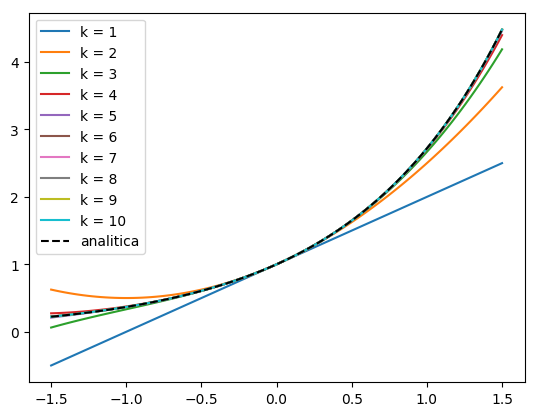

PyObject <matplotlib.legend.Legend object at 0x7efb2997cef0>

In [9]:
x = linspace(-1.5, 1.5, 100)
y = zeros(x)
x_ = Taylor([0.0, 1.0])

for k = gradomax(x_):(gradomax(x_) + 9)
    x_ = prom(x_, k)
    ec = exp(x_)
    for (i, j) = enumerate(x)
        y[i] = evaluacion(ec, j)
    end
    plot(x, y, label = "k = $(k - 1)")
end
plot(x, exp(x), "--", color = "black", label = "analitica")
legend()

Para el logaritmo realizamos el mismo procedimiento

$$ L(x) = log(g(x)) $$
$$ \frac{dL}{dx}(x) =  \frac{1}{g(x)} \frac{dg}{dx}(x) $$

Aqui si vemos a $ \frac{1}{g(x)} \frac{dg}{dx}(x) $ como
$$ \frac{g'}{g} = \sum_{k = 0}^{\infty} (\frac{g'}{g})_{[k]} (x - x_0)^k$$

Entonces tenemos

$$ \frac{dL}{dx}(x) = \sum_{k = 0}^{\infty} kL (x - x_0) ^{k - 1} = \sum_{k = 0}^{\infty} (\frac{g'}{g})_{[k]} (x - x_0)^k$$

por lo tanto

$$ L_{[k]} = \frac{1}{k} (\frac{g'}{g})_{[k]}$$

In [10]:
import Base: log

function log(a::Taylor)
    n = gradomax(a); # grado máximo

    Loga = Taylor(zeros(n));
    Loga.coef[1] = log(a.coef[1]);

    s = 1; # índice desde donde empezamos
    while a.coef[s] == 0
        s += 1
    end
    
    for k = (s+1):n
        suma = 0;
        
        for j = (s+1): k
            suma += (j-1)*Loga.coef[j]*a.coef[k-j+1];
        end
        Loga.coef[k] = (1/a.coef[s])*(a.coef[k]-suma/(k-s))
    end
    
    return Loga
end

log(a::Taylor, n::Integer) = log(prom(a, n)) 

log (generic function with 20 methods)

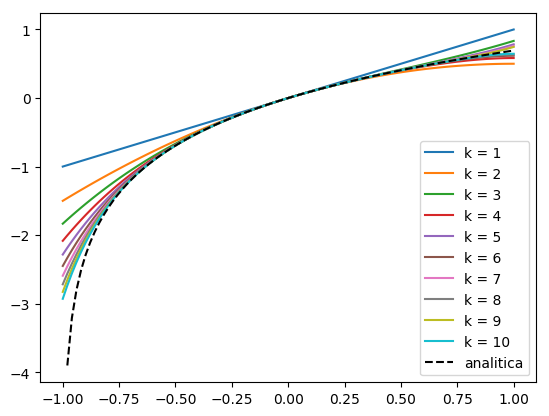

PyObject <matplotlib.legend.Legend object at 0x7efb2926b630>

In [11]:
x = linspace(-1.0, 1.0, 100)
y = zeros(x)
x_ = Taylor([1.0, 1.0])

for k = gradomax(x_):(gradomax(x_) + 9)
    x_ = prom(x_, k)
    ec = log(x_)
    for (i, j) = enumerate(x)
        y[i] = evaluacion(ec, j)
    end
    plot(x, y, label = "k = $(k - 1)")
end
plot(x, log(x + 1), "--", color = "black", label = "analitica")
legend()

Utilizando las definiciones anteriores podemos definir la funcion $P_{a}(x) = (g(x))^a$ como

$$ (g(x))^a = e^{a\log{(g(x))}}$$

In [12]:
import Base: ^

^(a::Taylor, N::Number) = exp(N * log(a))

function ^(a::Taylor, n::Integer)
    if n != 0
        pot = a
        for i = 2:n
            pot *= a
        end
        return pot
    else
        return Taylor([1])
    end
end

^ (generic function with 49 methods)

In [13]:
import Base: sin, cos

function sin(a::Taylor)
    A = exp(a * 1im)
    return Taylor(imag(A.coef))
end

sin(a::Taylor, n::Integer) = sin(prom(a, n))

function cos(a::Taylor)
    A = exp(a * 1im)
    return Taylor(real(A.coef))
end

cos(a::Taylor, n::Integer) = cos(prom(a, n))

cos (generic function with 12 methods)

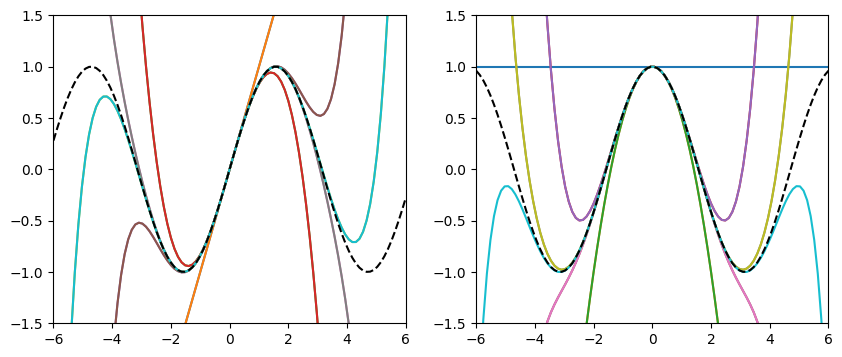

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efb26ca9d30>

In [14]:
x = linspace(-6, 6, 100)
y_s = zeros(x)
y_c = zeros(x)
x_ = Taylor([0.0, 1.0])

fig = figure(figsize = (10, 4))

ax = subplot(121)
bx = subplot(122)

ax[:set_xlim](-6, 6)
ax[:set_ylim](-1.5, 1.5)
bx[:set_xlim](-6, 6)
bx[:set_ylim](-1.5, 1.5)

for k = gradomax(x_):(gradomax(x_) + 9)
    x_ = prom(x_, k)
    ecs = sin(x_)
    ecc = cos(x_)

    for (i, j) = enumerate(x)
        y_s[i] = evaluacion(ecs, j)
        y_c[i] = evaluacion(ecc, j)

    end
    ax[:plot](x, y_s, label = "k = $(k - 1)")
    bx[:plot](x, y_c, label = "k = $(k - 1)")

end
ax[:plot](x, sin(x), "--", color = "black", label = "analitica")
bx[:plot](x, cos(x), "--", color = "black", label = "analitica")